# 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jmgarzonv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\jmgarzonv\Desktop\EAFIT\MMDS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Configurations

In [22]:
DATA_PATH = r"WELFake_Dataset.csv"
news_data = pd.read_csv(DATA_PATH)

In [3]:
class_names = ['fake', 'real'] # 0: fake, 1: real

In [24]:
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [25]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [26]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [27]:
news_data = news_data.fillna('')

In [28]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [29]:
news_data.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

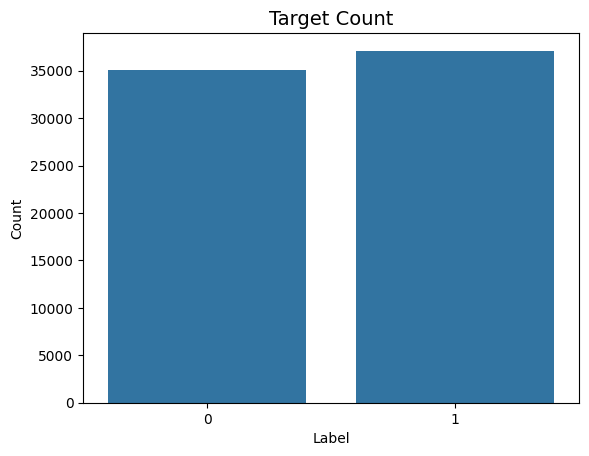

In [30]:
label_count = news_data['label'].value_counts().reset_index()
label_count.columns = ['label', 'count']

sns.barplot(x='label', y='count', data=label_count)
plt.title('Target Count', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# 3. Building Dataset

### Stemming & Extracting text data using TF-IDF

In [31]:
port = PorterStemmer()

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

Since there are too many text data, we extracted only important words using TF-IDF.

In [32]:
def refinement_tfidf(text): # TF-IDF
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names_out())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [33]:
import swifter

# Get the first 5 rows
# news_data = news_data.head()

t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].swifter.apply(refinement_tfidf)
print(time.time() - t0) # It takes about 45 minutes...
print(news_data['refined_tfidf'].head())

Pandas Apply: 100%|██████████| 72134/72134 [1:28:22<00:00, 13.60it/s]  


5500.213385105133
0                                                 said
1                            alreadi hillari post vote
2    aka chang constitut creat demonstr eric exerci...
3                                               jindal
4     design dub km mile missil rs sarmat satan weapon
Name: refined_tfidf, dtype: object


In [34]:
# Save the DataFrame to a CSV file
output_file_path = 'news_data_with_refined_tfidf.csv'
news_data.to_csv(output_file_path, index=False, sep=';')

In [4]:
news_data = pd.read_csv('news_data_with_refined_tfidf.csv', sep=';')

In [5]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,said
1,1,NaN,Did they post their votes for Hillary already?,1,alreadi hillari post vote
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,aka chang constitut creat demonstr eric exerci...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,jindal
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,design dub km mile missil rs sarmat satan weapon


In [6]:
labels = news_data['label'].values
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

### Tokenization

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

Militant threat hangs over Islamic State's former Libyan stronghold sirt
['militant', 'threat', 'hangs', 'over', 'islamic', 'state', "'", 's', 'former', 'libyan', 'stronghold', 'sir', '##t']
[16830, 5081, 17991, 2058, 5499, 2110, 1005, 1055, 2280, 19232, 16995, 2909, 2102]


In [25]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

ValueError: Input nan is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

<Axes: >

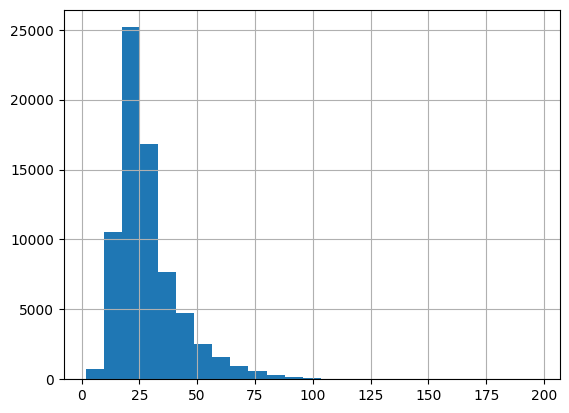

In [40]:
pd.Series(id_len).hist(bins=25)

In [13]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs.any():
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [46]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

[1 1 1 ... 0 0 1]


(57707, 14427)

In [47]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

# 4. Loading Deep Learning Model

We used BERT for natural language processing based on deep learning model.

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [49]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=6e-6,
                              eps=1e-8)

In [50]:
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 5. Training

In [51]:
model.train()

total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            


c:\Users\jmgarzonv\Desktop\EAFIT\MMDS\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


3200 / 57707
6400 / 57707
9600 / 57707
12800 / 57707
16000 / 57707
19200 / 57707
22400 / 57707
25600 / 57707
28800 / 57707
32000 / 57707
35200 / 57707
38400 / 57707
41600 / 57707
44800 / 57707
48000 / 57707
51200 / 57707
54400 / 57707
57600 / 57707
Epoch: 1, Loss: 0.2217
3200 / 57707
6400 / 57707
9600 / 57707
12800 / 57707
16000 / 57707
19200 / 57707
22400 / 57707
25600 / 57707
28800 / 57707
32000 / 57707
35200 / 57707
38400 / 57707
41600 / 57707
44800 / 57707
48000 / 57707
51200 / 57707
54400 / 57707
57600 / 57707
Epoch: 2, Loss: 0.1216
3200 / 57707
6400 / 57707
9600 / 57707
12800 / 57707
16000 / 57707
19200 / 57707
22400 / 57707
25600 / 57707
28800 / 57707
32000 / 57707
35200 / 57707
38400 / 57707
41600 / 57707
44800 / 57707
48000 / 57707
51200 / 57707
54400 / 57707
57600 / 57707
Epoch: 3, Loss: 0.0809
3200 / 57707
6400 / 57707
9600 / 57707
12800 / 57707
16000 / 57707
19200 / 57707
22400 / 57707
25600 / 57707
28800 / 57707
32000 / 57707
35200 / 57707
38400 / 57707
41600 / 57707
44800

In [52]:
import os
os.makedirs('nets', exist_ok=True)
torch.save(model.state_dict(), 'nets/BERT.ckpt')

# 6. Evaluation

In [11]:
model.eval()
model.load_state_dict(torch.load('nets/BERT.ckpt', map_location=device))

<All keys matched successfully>

In [54]:
score = 0
for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))

Accuracy: 0.9605



It showed 96.15% performance!

# 7. Run Demo

In [16]:
for i in range(5):
    idx = np.random.choice(range(len(news_data)))

    print('\033[1m'+news_data['title'][idx]+'\n')
    print('\033[0m'+news_data['text'][idx])

    label = news_data['label'][idx]
    text = news_data['title'][idx] + ' ' + news_data['refined_tfidf'][idx]

    input_id, attention_mask = tokenize_map([text], np.array([]))

    g_label = model(input_id.to(device), token_type_ids=None, attention_mask=attention_mask.to(device))[0]
    pred = torch.max(g_label, 1)[1][0].item()

    print('\n')
    print('Predict: {}'.format(class_names[pred]))
    print('GT: {}'.format(class_names[label]))
    print('---------------------------------------------------------------------------------------------\n')

YOU’LL NEVER GUESS Who The New York Times Is Blaming For North Korea’s Decades-Long Famine

After North Korea s most recent missile launch, the North Korean dictator, Kim Jong Un claimed he had  finally realized the great historic cause of completing the state nuclear force.  US Defense Secretary James Mattis claimed that North Korea now has the ability to hit  everywhere in the world. Meanwhile, the New York Times is blaming the Trump administration for starving the North Koreans, after placing stricter sanctions on the rogue nation.The left-leaning New York Times bizarrely claimed this week that the decades-long famine plaguing North Korea is not the fault of its brutal communist regime, but most likely due to American interference and foreign policy, saying the  hunger is devastating. And it s our fault. The article, published over the weekend, lays the blame of millions of starved and tortured North Koreans at the feet of the American administration, saying the US and its allies ha